In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score



# read dataset and replace -200 by NaN
dataset = pd.read_excel("AirQualityUCI _ Students.xlsx")
dataset.replace(-200, np.nan, inplace=True)

# preprocess my dataset, convert date and time to year month day hour
def trans_Datetime(dataset):
    dataset_time = dataset.copy()
    
    # Convert 'Date' to timestamp directly
    dataset_time['Date'] = pd.to_datetime(dataset_time['Date']).view('int64') // 10**9
    
    # Convert 'Time' to seconds since midnight
    dataset_time['Time'] = pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.hour * 3600 \
                         + pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.minute * 60 \
                         + pd.to_datetime(dataset_time['Time'], format='%H:%M:%S').dt.second
    
    # Combine 'Date' and 'Time' to create 'DateTime_numeric'
    dataset_time['DateTime_numeric'] = dataset_time['Date'] + dataset_time['Time']
    
    # Convert 'DateTime_numeric' to datetime
    dataset_time['datetime'] = pd.to_datetime(dataset_time['DateTime_numeric'], unit='s')
    
    # Extract components from 'datetime'
    dataset_time['year'] = dataset_time['datetime'].dt.year
    dataset_time['month'] = dataset_time['datetime'].dt.month
    dataset_time['day'] = dataset_time['datetime'].dt.day
    dataset_time['hour'] = dataset_time['datetime'].dt.hour
    
    return dataset_time

# simply delete the miss value
def deletion_pre(dataset):
    dataset_de = dataset.drop(['NMHC(GT)'],axis=1)
    
    dataset_de.dropna(inplace=True)
    dataset_de = trans_Datetime(dataset_de)
    
    dataset_de.drop(['Date','Time','DateTime_numeric','datetime'],axis=1, inplace=True)

    return dataset_de

# use fillforward and mean to fill the miss value
def imputation_pre(dataset):
    dataset_im = trans_Datetime(dataset)
    dataset_im['Date'].fillna(method='ffill', inplace=True)
    dataset_im['Time'].fillna(method='ffill', inplace=True)
    
    dataset_im.drop(['Date', 'Time', 'DateTime_numeric', 'datetime'], axis=1, inplace=True)

    dataset_im.fillna(dataset_im.mean(), inplace=True)

    return dataset_im






dataset_de = deletion_pre(dataset)
dataset_im = imputation_pre(dataset)


def split_set_classify(dataset):
    co_mean = sum(dataset['CO(GT)'])/len(dataset['CO(GT)'])
    if 'NMHC(GT)' in dataset.columns:
    
        X = dataset.drop(['CO(GT)', 'NMHC(GT)'], axis=1)
    else:
   
        X = dataset.drop(['CO(GT)'], axis=1)
    y = (dataset['CO(GT)'] > co_mean).astype(int)  # Binary target: 1 if CO(GT) > mean, 0 otherwise

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

def split_set_reg(dataset):
    
    X_re = dataset.drop(['NOx(GT)','NMHC(GT)'], axis=1)
    y_re = dataset['NOx(GT)']

    X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_re, y_re, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled_re = scaler.fit_transform(X_train_re)
    X_test_scaled_re = scaler.transform(X_test_re)
    return X_train_scaled_re, X_test_scaled_re, y_train_re, y_test_re

def plot_pic(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Plot for the Classification Task')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Plot for the Classification Task')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()
    
def plot_pic_reg(history,model,X_test_scaled_re,y_test_re):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (DNN)')
    plt.plot(history.history['val_loss'], label='Validation Loss (DNN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    y_pred = model.predict(X_test_scaled_re)
    plt.subplot(2, 1, 2)
    plt.plot(y_test_re.values, label='Actual NOx(GT)', alpha=0.6)
    plt.plot(y_pred, label='Predicted NOx(GT)', alpha=0.6)
    plt.xlabel('Sample Index')
    plt.ylabel('NOx(GT)')
    plt.title('Actual vs Predicted NOx(GT)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return y_pred
    
def model_performance(X_test,y_test,model):

    # model_save = load_model('my_model.h5')
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to classes (assuming threshold of 0.5)
    y_pred = (y_pred_prob > 0.5).astype(int)
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Extract TP, FP, TN, FN
    TN, FP, FN, TP = conf_matrix.ravel()
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    # Compute precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    # Number of tested samples
    num_samples = len(y_test)
    print(f"Number of tested samples: {num_samples}")
    # Display confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

Epoch 1/100
76/76 [==============================] - 1s 4ms/step - loss: 0.2788 - accuracy: 0.8797 - val_loss: 0.1934 - val_accuracy: 0.9275
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9250 - val_loss: 0.1792 - val_accuracy: 0.9275
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1888 - accuracy: 0.9289 - val_loss: 0.1803 - val_accuracy: 0.9267
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.9289 - val_loss: 0.1733 - val_accuracy: 0.9308
Epoch 5/100
76/76 [==============================] - 0s 1ms/step - loss: 0.1814 - accuracy: 0.9283 - val_loss: 0.1725 - val_accuracy: 0.9292
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.9349 - val_loss: 0.1717 - val_accuracy: 0.9316
Epoch 7/100
76/76 [==============================] - 0s 2ms/step - loss: 0.1770 - accuracy: 0.9294 - val_loss: 0.1769 - val_accuracy: 0.9292
Epoch 8/100
7

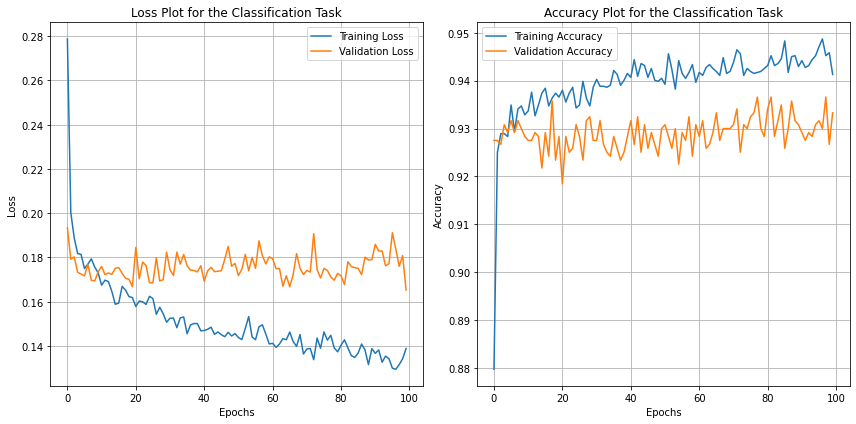

38/38 [==============================] - 0s 728us/step
Accuracy: 0.9333
Precision: 0.9067
Number of tested samples: 1214
Confusion Matrix:
[[676  47]
 [ 34 457]]


In [11]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

X_train_scaled_de = split_set_classify(dataset_de)[0]
X_test_scaled_de = split_set_classify(dataset_de)[1]
y_train_de = split_set_classify(dataset_de)[2]
y_test_de = split_set_classify(dataset_de)[3]
model = Sequential([
    Dense(28, activation='relu', input_shape=(X_train_scaled_de.shape[1],)),
    Dropout(0.2),
    Dense(13, activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')  # Sigmoid activation for binary classification
])

optimizer = Adam(learning_rate=0.008)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history_class_re = model.fit(X_train_scaled_de, y_train_de, epochs=100, batch_size=64, 
                        validation_data=(X_test_scaled_de, y_test_de))
loss, accuracy = model.evaluate(X_test_scaled_de, y_test_de)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')
model.summary()

# np.save('training_history.npy', history.history)
# model.save('my_model.h5')

plot_pic(history_class_re)

model_performance(X_test_scaled_de, y_test_de, model)



Epoch 1/100
105/105 [==============================] - 1s 2ms/step - loss: 0.3198 - accuracy: 0.8563 - val_loss: 0.2687 - val_accuracy: 0.8786
Epoch 2/100
105/105 [==============================] - 0s 1ms/step - loss: 0.2709 - accuracy: 0.8850 - val_loss: 0.2584 - val_accuracy: 0.8774
Epoch 3/100
105/105 [==============================] - 0s 1ms/step - loss: 0.2586 - accuracy: 0.8916 - val_loss: 0.2476 - val_accuracy: 0.8792
Epoch 4/100
105/105 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.8910 - val_loss: 0.2411 - val_accuracy: 0.8756
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 0.2435 - accuracy: 0.8961 - val_loss: 0.2362 - val_accuracy: 0.8876
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.2379 - accuracy: 0.9008 - val_loss: 0.2313 - val_accuracy: 0.8935
Epoch 7/100
105/105 [==============================] - 0s 1ms/step - loss: 0.2363 - accuracy: 0.9052 - val_loss: 0.2290 - val_accuracy: 0.9007

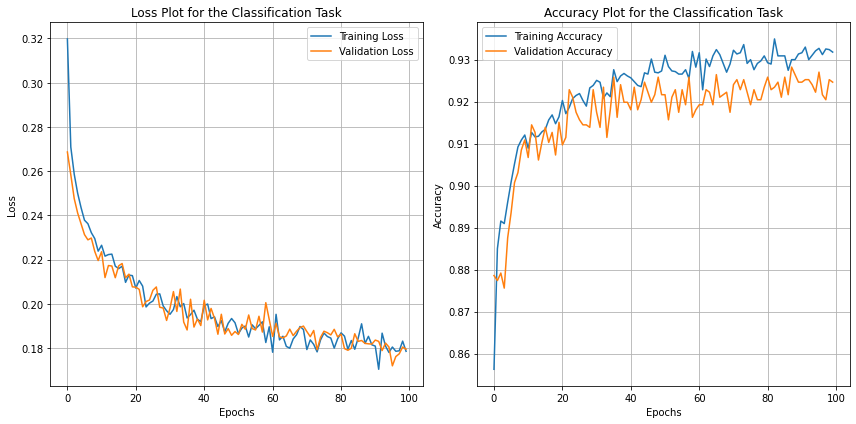

53/53 [==============================] - 0s 949us/step
Accuracy: 0.9246
Precision: 0.9188
Number of tested samples: 1672
Confusion Matrix:
[[1048   44]
 [  82  498]]


In [6]:
# for imputation
X_train_scaled = split_set_classify(dataset_im)[0]
X_test_scaled = split_set_classify(dataset_im)[1]
y_train = split_set_classify(dataset_im)[2]
y_test = split_set_classify(dataset_im)[3]
model = Sequential([
    Dense(28, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(13, activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')  # Sigmoid activation for binary classification
])

optimizer = Adam(learning_rate=0.008)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history_class = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, 
                        validation_data=(X_test_scaled, y_test))
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')
model.summary()

# np.save('training_history.npy', history.history)
# model.save('my_model.h5')  
plot_pic(history_class)

model_performance(X_test_scaled, y_test, model)



In [26]:
X_train_scaled_re = split_set_reg(dataset_im)[0]
X_test_scaled_re = split_set_reg(dataset_im)[1]
y_train_re = split_set_reg(dataset_im)[2]
y_test_re = split_set_reg(dataset_im)[3]
reg_model = Sequential([
    Dense(26, activation='relu', input_shape=(X_train_scaled_re.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
reg_model.summary()
reg_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_reg = reg_model.fit(X_train_scaled_re, y_train_re, epochs=100, batch_size=64, 
                            validation_data=(X_test_scaled_re, y_test_re))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 26)                416       
                                                                 
 dense_28 (Dense)            (None, 16)                432       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
92/92 [==============================] - 1s 2ms/step - loss: 96554.7578 - mae: 244.6714 - val_loss: 94892.4375 - val_mae: 241.5660
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 87058.5625 - mae: 230.8498 - val_loss: 76241.6250 - val_mae: 214.0439
Epoch 3/100
92/92 [===============

79/79 [==============================] - 0s 859us/step


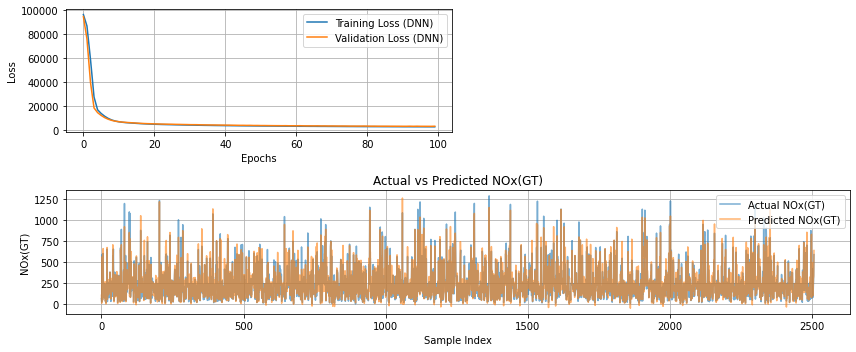

79/79 [==============================] - 0s 993us/step - loss: 3492.0334 - mae: 39.3712
DNN Test Loss: 3492.0334, Test MAE: 39.3712
RMSE: 59.0934, MAE: 39.3712


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


y_pred = plot_pic_reg(history_reg,reg_model, X_test_scaled_re, y_test_re )

re_loss, re_mae = reg_model.evaluate(X_test_scaled_re, y_test_re)

rmse = np.sqrt(mean_squared_error(y_test_re, y_pred))
mae = mean_absolute_error(y_test_re, y_pred)
print(f'DNN Test Loss: {re_loss:.4f}, Test MAE: {re_mae:.4f}')
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')
